Rui Wang 1007791695

# Metropolis within Gibbs

In [3]:
from scipy import stats; import numpy as np; import matplotlib.pyplot as plt
mu_0,sigma_0=0,10
loc_prior = stats.norm(loc=mu_0, scale=sigma_0) # mean=mu_0 / std=sigma_0
scale_prior = stats.halfnorm(scale=5) # std=1
df_prior = stats.randint(low=1, high=101) # df ~ Unif{1, 2, ..., 100}

n,loc_true,scale_true,df_true = 100,10,2,15 # True values data will be from... IRL, we don't know these values
x = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(n) # Data from location-scale-t distribution

loglikelihood = lambda loc,scale,df: stats.t(loc=loc, scale=scale, df=df).logpdf(x).sum()
logjoint_eval_at_x = lambda loc,scale,df: (loglikelihood(loc,scale,df)+\
                                           loc_prior.logpdf(loc)+scale_prior.logpdf(scale)+df_prior.logpmf(df))

loc_perturbation_MH_proposal_tuning_parameter = 0.1
loc_perturbation_MH_proposal_distribution = stats.norm(scale=loc_perturbation_MH_proposal_tuning_parameter)
# `loc_prior`  : p(mu(t-1)|mu*)/p(mu*|mu(t-1)) = 1 since it's a symmetric proposal

# ... going to use `scale_prior` and `df_prior` as fixed i.i.d. MH proposal distribuitions
scale_fixed_iid_MH_proposal_distribution = scale_prior # tuning parameters taken to be prior hyperparameters
df_fixed_iid_MH_proposal_distribution = df_prior # tuning parameters taken to be prior hyperparameters
# `scale_prior`: p(sd(t-1)|sd*)/p(sd*|sd(t-1)) = p(sd(t-1))/p(sd*) is an easy pdf ratio
# `df_prior`   : p(df(t-1)|df*)/p(df*|df(t-1)) = (1/100)/(1/100) = 1 can be ignored

# Metropolis within Gibbs

In [4]:
T=1000; loc_MH_samples,scale_MH_samples,df_MH_samples = np.ones(T),np.ones(T),np.ones(T)
for t in range(1,T):

    # loc
    current_loc = loc_MH_samples[t-1]; proposed_loc = current_loc + loc_perturbation_MH_proposal_distribution.rvs()
    log_acceptance_probability = logjoint_eval_at_x(proposed_loc, scale_MH_samples[t-1], df_MH_samples[t-1])-\
                                 logjoint_eval_at_x(current_loc, scale_MH_samples[t-1], df_MH_samples[t-1])
    loc_MH_samples[t] = [current_loc,proposed_loc][int(stats.uniform().rvs() < np.exp(log_acceptance_probability))]

    # scale
    current_scale = scale_MH_samples[t-1]; proposed_scale = scale_fixed_iid_MH_proposal_distribution.rvs()
    logtarget_ratio = logjoint_eval_at_x(loc_MH_samples[t], proposed_scale, df_MH_samples[t-1])-\
                      logjoint_eval_at_x(loc_MH_samples[t], current_scale, df_MH_samples[t-1])
    logMH_proposal_correction_factor = scale_fixed_iid_MH_proposal_distribution.logpdf(current_scale)-\
                                       scale_fixed_iid_MH_proposal_distribution.logpdf(proposed_scale)
    acceptance_probability = np.exp(logtarget_ratio+logMH_proposal_correction_factor)
    scale_MH_samples[t] = [current_scale,proposed_scale][int(stats.uniform().rvs() < acceptance_probability)]

    # df
    current_df = df_MH_samples[t-1]; proposed_df = df_fixed_iid_MH_proposal_distribution.rvs()
    log_acceptance_probability = logjoint_eval_at_x(loc_MH_samples[t], scale_MH_samples[t], proposed_df)-\
                                 logjoint_eval_at_x(loc_MH_samples[t], scale_MH_samples[t], current_df)
    df_MH_samples[t] = [current_df,proposed_df][int(stats.uniform().rvs() < np.exp(log_acceptance_probability))]

# Metropolis within Gibbs

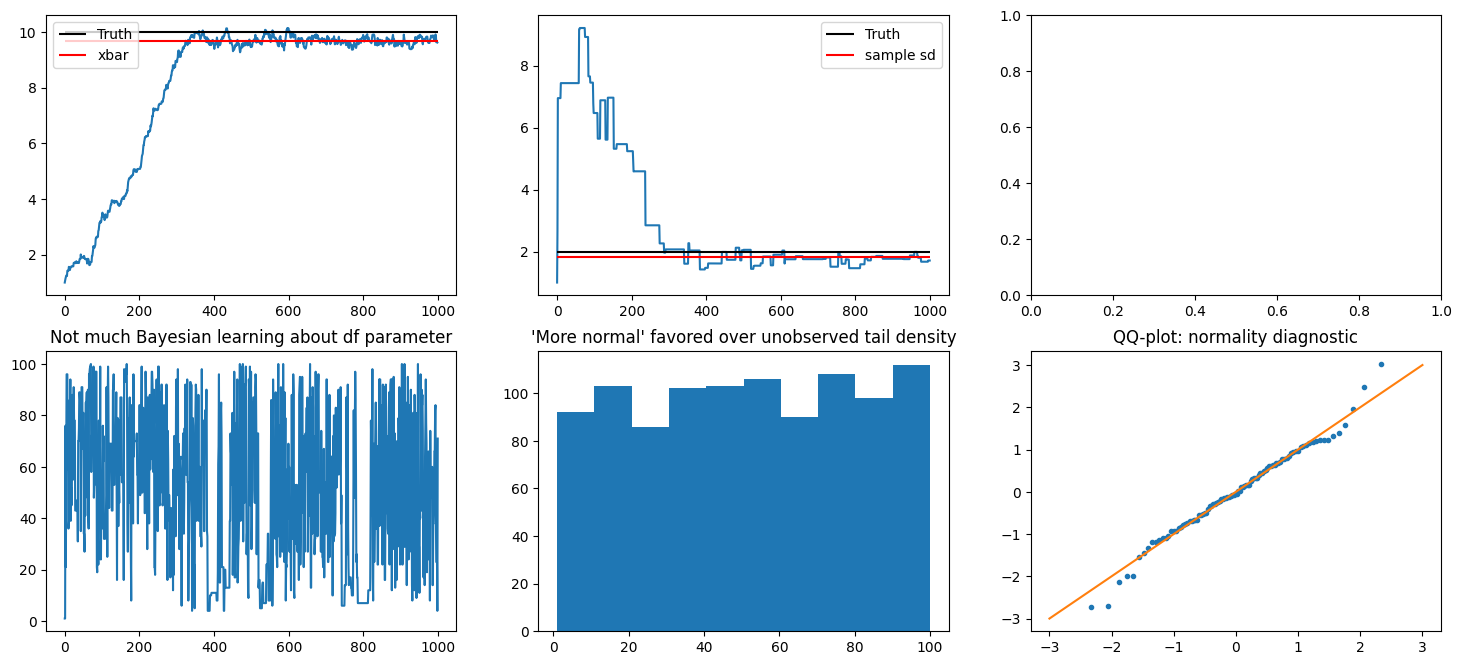

In [5]:
fig,ax = plt.subplots(2,3,figsize=(18,8))
ax[0,0].plot(loc_MH_samples); ax[0,0].hlines(loc_true,xmin=0,xmax=T,label='Truth',color='black'); ax[0,0].hlines(x.mean(),xmin=0,xmax=T,label='xbar',color='red'); ax[0,0].legend(); ax[0,1].plot(scale_MH_samples); ax[0,1].hlines(scale_true,xmin=0,xmax=T,label='Truth',color='black'); ax[0,1].hlines(x.std(),xmin=0,xmax=T,label='sample sd',color='red'); ax[0,1].legend(); ax[1,0].plot(df_MH_samples); ax[1,1].hist(df_MH_samples); ax[1,0].set_title("Not much Bayesian learning about df parameter");  ax[1,1].set_title("'More normal' favored over unobserved tail density"); ax[1,2].plot(stats.norm.ppf(np.linspace(0,1,n+2))[1:-1],sorted((x-x.mean())/x.std()),'.'); ax[1,2].plot([-3,3],[-3,3]); ax[1,2].set_title("QQ-plot: normality diagnostic");

# Homework #4 Part I: Fit this model using HMC in `PyMC`

For the model specification example considered in "Metropolis within Gibbs" above...


## Provide posterior analysis for this model using "default" `PyMC`

- Don't try to do "Metropolis within Gibbs" `in PyMC` -- you can't -- use the default HMC sampler
- You can do this without knowing what HMC is: you've already previously used HMC with `PyMC`; and, you can go get the distributions you need [here...](https://www.pymc.io/projects/docs/en/stable/api/distributions.html)
- ***Explore and describe the sample sizes needed to support inference regarding the `df` parameter $(\nu)$***

*Ahem...*

- Is it eating you up inside that you don't know what HMC actualy is?
- Do you hate just using something without knowing what it is?<br>Or what you're even doing when you use it?

*Well then, my friends, have I got the cure for you!*<br>All **you** must **do** is listen **to** someone **who** will re**view** for **you** the next slides **few**!


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Effective sample size for df parameter: df    4.78
Name: ess_bulk, dtype: float64


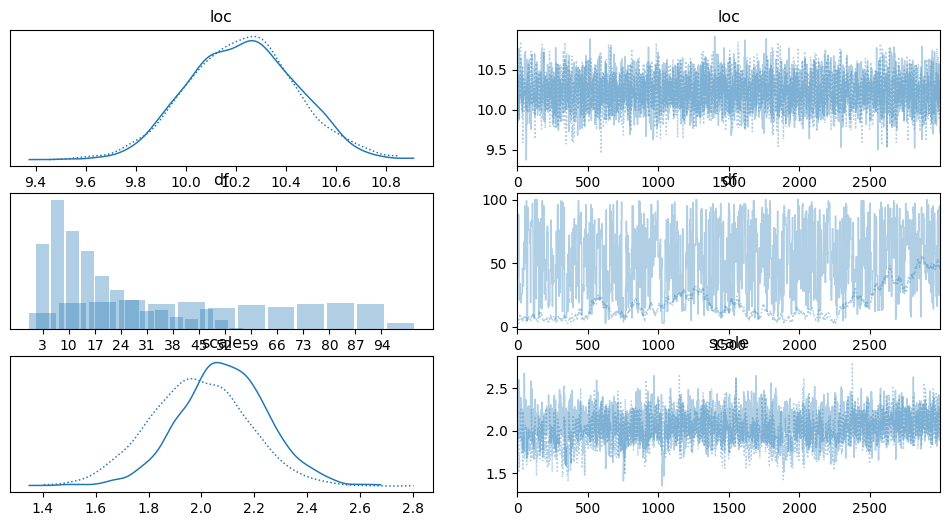

In [8]:
from scipy import stats; import numpy as np; import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# We pick some true values from Bayes4_MHandHMCandMoreDiagnostics-Copy1 to help us build the model.
mu_0, sigma_0 = 0, 10
n, loc_true, scale_true, df_true = 100, 10, 2, 15

x = stats.t(df = df_true, loc = loc_true, scale = scale_true).rvs(n)

# Bayesian Model(PyMC)
with pm.Model() as model:
    loc = pm.Normal("loc", mu = mu_0, sigma = sigma_0)
    scale = pm.HalfNormal("scale", sigma = 5)
    df = pm.DiscreteUniform("df", lower = 1, upper = 100)
    x_obs = pm.StudentT("x_obs", mu = loc, lam = 1/scale**2, nu = df, observed = x)
    trace = pm.sample(draws = 3000, tune = 2000, target_accept = 0.95)

az.plot_trace(trace)
az.summary(trace, round_to = 2)

df_summary = az.summary(trace, var_names = ["df"], round_to = 2)
df_ess = df_summary["ess_bulk"]
print(f"Effective sample size for df parameter: {df_ess}")

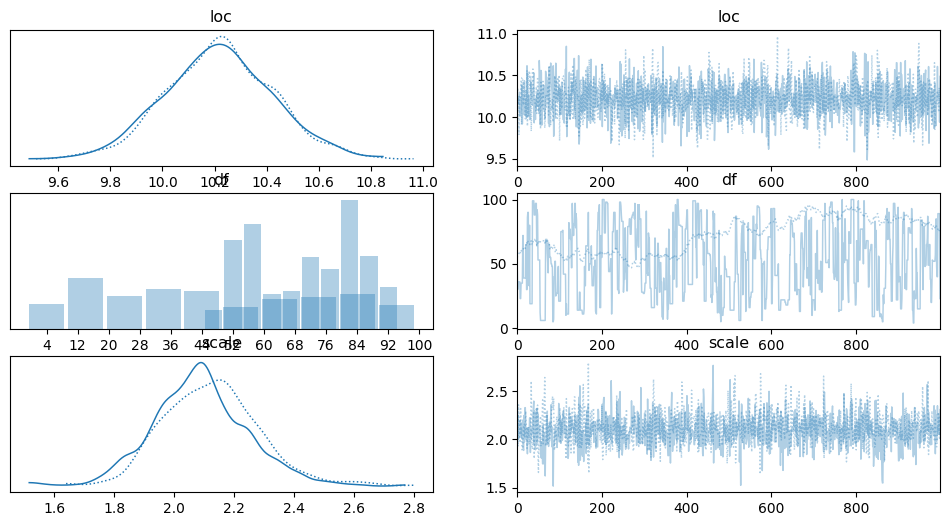

In [9]:
import pymc as pm

with pm.Model() as t_norm_half_norm_discrete:
    loc = pm.Normal("loc", mu = 0, sigma = 10)
    scale = pm.HalfNormal("scale", sigma = 5)
    df = pm.DiscreteUniform("df", lower = 1,upper = 100)
    x_obs = pm.StudentT("likelihood", mu = loc, sigma = scale, nu = df, observed = x)

with t_norm_half_norm_discrete:
    idata = pm.sample()

import arviz as az; az.plot_trace(idata);

# Symplectic Integration

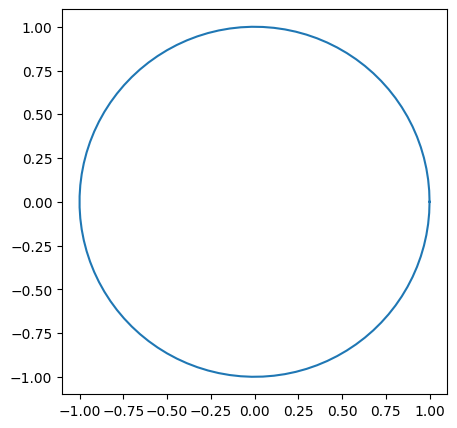

In [10]:
import matplotlib.pyplot as plt; import numpy as np
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5)); t = np.linspace(0,2*np.pi, 100)
ax.plot(np.cos(t), -np.sin(t)); ax.set_aspect('equal', adjustable='box') # https://www.delftstack.com/howto/matplotlib/how-to-make-a-square-plot-with-equal-axes-in-matplotlib/

# Symplectic Integration

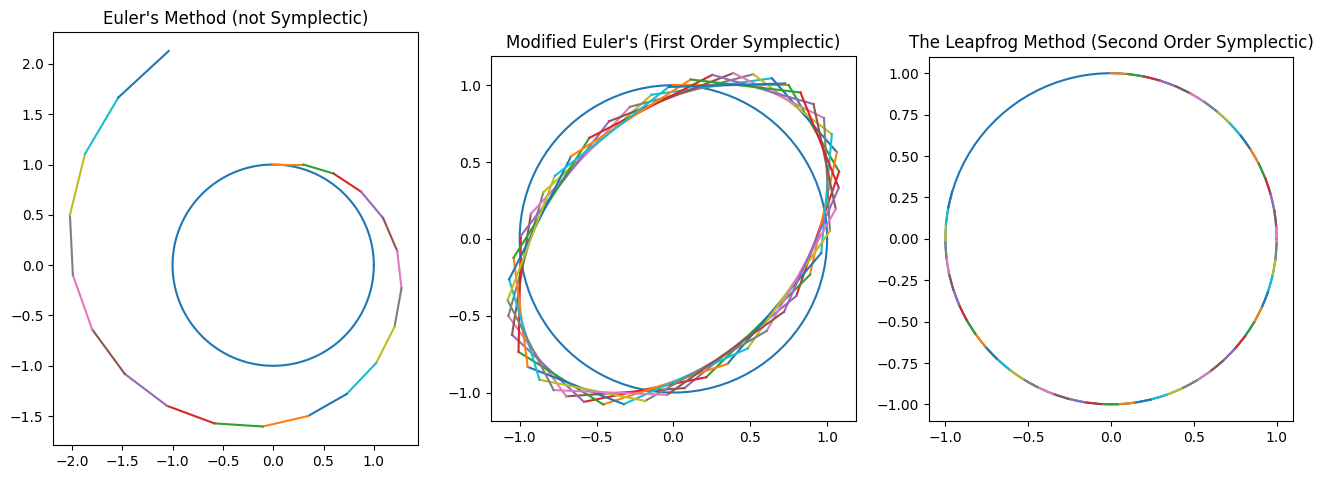

In [11]:
import matplotlib.pyplot as plt; import numpy as np; t = np.linspace(0,2*np.pi, 100); fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,8))
for i in range(3):
    ax[i].plot(np.cos(t), -np.sin(t)); ax[i].set_aspect('equal', adjustable='box')
theta_t, v_t, t, epsilon = 0, 1, 0, .3; ax[0].set_title("Euler's Method (not Symplectic)")
for i in range(20):
    v_t_e = v_t - epsilon * theta_t; theta_t_e = theta_t + epsilon * v_t; ax[0].plot([theta_t, theta_t_e], [v_t, v_t_e])
    theta_t, v_t, t = theta_t_e, v_t_e, t+epsilon
theta_t, v_t, t, epsilon = 0, 1, 0, .75; ax[1].set_title("Modified Euler's (First Order Symplectic)")
for i in range(50):
    v_t_e = v_t - epsilon * theta_t; theta_t_e = theta_t + epsilon * v_t_e; ax[1].plot([theta_t, theta_t_e], [v_t, v_t_e])
    theta_t, v_t, t = theta_t_e, v_t_e, t+epsilon
theta_t, v_t, t, epsilon = 0, 1, 0, .1; ax[2].set_title("The Leapfrog Method (Second Order Symplectic)")
for i in range(50):
    v_t_e = v_t - epsilon / 2 * theta_t; theta_t_e = theta_t + epsilon * v_t_e; v_t_e = v_t_e - epsilon / 2 * theta_t_e; ax[2].plot([theta_t, theta_t_e], [v_t, v_t_e])
    theta_t, v_t, t = theta_t_e, v_t_e, t+epsilon

# Homework #4 Part II: HMC Diagnostics

- Return to your posterior analysis in "Homework #4 Part I" and
report on (a) ***effective sample sizes***; (b) ***chain convergence measures***; (c) ***divergences***; (d) ***Metropolis-Hastings acceptance rates*** [see below for how to access these]; and (e) any other warnings or concers provided by `PyMC`

- Now examine the [Eight Schools](https://github.com/pointOfive/STA410_W24_StatisticalComputation/blob/main/Week3/STA410_W24_Week3_Demo_HMCwithPyMC.ipynb) example PyMC model and outputted results
    - Provide an analogous report regarding (a)-(e) above for the "centered" and "uncentered" Eight Schools models
        - *Hint: for (d) see `fit_C.sample_stats.acceptance_rate.values.flatten()` and `fit_NC.sample_stats.acceptance_rate.values.flatten()` and in the Eight Schools example*
    - From the perspective of ***curvature*** of the ***energy function*** (that is, how rapidly the ***log joint posterior distribution density*** changes for different values of its ***random variable (parameters)*** and the effectiveness of the ***HMC*** algorithm, explain why the "uncentered" paramterization of the model performs better than the "centered" parameterization
        - *Hint: see the previous two slides...*
- Review [this](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#model-checking) and [that](https://discourse.pymc.io/t/about-nuts-sampling-and-energy-plot/831) discussing the ***diagnostic plot*** which compares the ***observed energy proposal distribution*** versus the ***empirical energy distribution*** of the generated HMC samples
    - Use the code on the next slide to provide and interpret the ***diagnostic plot*** assessing ***energy proposals*** versus the empirical ***energy*** distribution to compare and contrast the "centered" and "uncentered" Eight Schools models in relation to you previous comparision of these two model parameterization in terms of ***energy function curvature*** and the effectiveness of the ***HMC*** algorithm... does this diagnostic support your previous conclusions in these regards?


In [16]:
# Gain the codes and values from Eight schools example(https://github.com/pointOfive/STA410_W24_StatisticalComputation/blob/main/Week3/STA410_W24_Week3_Demo_HMCwithPyMC.ipynb)
import numpy as np
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

import pymc as pm

with pm.Model() as Centered_eight:

    # We assume the following prior distributions for our parameters
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)

    # and we assume the following probabilistic hierarchy
    # within the data generating mechanism
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J) # theta is length J=8

    # Note that if tau was small, then the density evalution above
    # could change rapidly for changes in theta
    # This means that the energy has high curvature

    # likelihood where observed information enters into the model
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

pm.model_to_graphviz(Centered_eight)

# This posterior distribution implied by this specification can be sampled from
# using HMC where the necessary auxiliary variables are added "under the hood"
SEED = [20100420, 20134234] # random seeds for each of two run HMC chains

with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

with pm.Model() as NonCentered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    # Changes in theta now take place on a fixed scale that is independent of tau

    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    # Changes in tau can still result in rapid changes in the density evaluations
    # below so the energy still has high curvature with respect to tau; but,
    # it no longer has high curvature with respect to theta
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

with NonCentered_eight:
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})

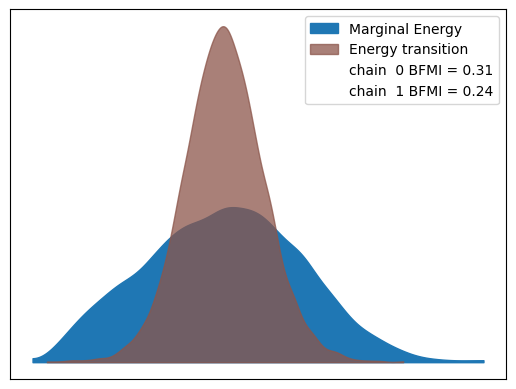

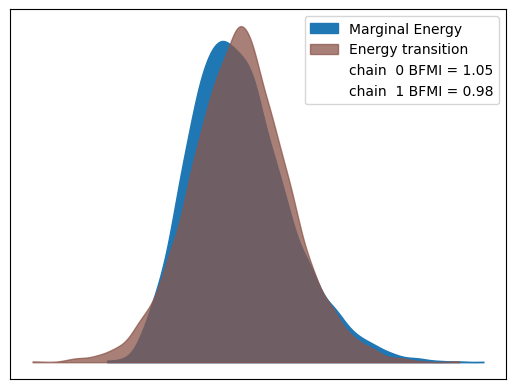

In [17]:
import arviz as az
az.plot_energy(fit_C);
az.plot_energy(fit_NC);

From the "centered" model in the figure(upper), it can be seen that the Bayesian BFMI of the two chains are very low, 0.31 and 0.24 respectively, indicating that the distribution of energy transition does not match the marginal energy distribution very well. This indicates a problem with sampling efficiency and suggests that "centered" model parameterization may make it difficult for HMC to effectively examine the posterior distribution.

From the "uncentered" model in the figure(lower), the BFMI values are closer to 1, 1.05 and 0.98 respectively, which indicates a good match between the energy transition and the marginal energy distribution. This means that the "uncentered" model parameterization helps the HMC to examine the posterior distribution more effectively, and the "uncentered" model is more consistent with the marginal energy function and energy transition function.

Analyzing both the "centered" model and the "uncentered" model, it can be concluded that the "uncentered" model improves the HMC approach by reducing potential problems in the posterior distribution that may hinder effective sampling. Compared with the "centered" model, the BFMI value in the "uncentered" model is higher and closer to 1, and there is a better match between the energy transition curve and the marginal energy distribution curve.

In summary, the graphs show that the “uncentered” model provides a more helpful basis for HMC to generate valid samples from the posterior distribution, which supports the previous conclusion that “uncentered” is more effective for HMC sampling efficiency.

